# Sound Dataset Exploration

## We Install Packages

Then Install:
- Audio processing: `librosa`, `mutagen`
- Plots: `Plotly`, `matplotlib`

In [16]:
!pip install pandas
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install mutagen
!pip install pillow

In [17]:
import os
import time
import librosa
import zipfile
import mutagen
import mutagen.wave
import numpy as np
import pandas as pd
import librosa.display
import IPython.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

## Data Processing

In [18]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-11-27 12:01:24--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2023-11-27 12:01:25--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  23.9MB/s    in 3m 58s  

2023-11-27 12:05:24 (24.1 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [19]:
!cat UrbanSound8K/UrbanSound8K_README.txt

UrbanSound8K

Created By
----------

Justin Salamon*^, Christopher Jacoby* and Juan Pablo Bello*
* Music and Audio Research Lab (MARL), New York University, USA
^ Center for Urban Science and Progress (CUSP), New York University, USA
http://serv.cusp.nyu.edu/projects/urbansounddataset
http://marl.smusic.nyu.edu/
http://cusp.nyu.edu/

Version 1.0


Description
-----------

This dataset contains 8732 labeled sound excerpts (<=4s) of urban sounds from 10 classes: air_conditioner, car_horn, 
children_playing, dog_bark, drilling, engine_idling, gun_shot, jackhammer, siren, and street_music. The classes are 
drawn from the urban sound taxonomy described in the following article, which also includes a detailed description of 
the dataset and how it was compiled:

J. Salamon, C. Jacoby and J. P. Bello, "A Dataset and Taxonomy for Urban Sound Research", 
22nd ACM International Conference on Multimedia, Orlando USA, Nov. 2014.

All excerpts are taken from field recordings uploaded to www.freesou

## Analysis of Data

We'll go through a series of data analysis procedures to look for trends in the provided data and select the most appropriate models in light of those findings.



### Informational Statistics

We are interested in seeing how the various classes are divided up and how the audio files were captured.  






In [20]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [21]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                                     filepath  
0          dog_bark    UrbanSound8K/audio/fold5/100032-3-0-0.wav  
1  children_playing  UrbanSound8K/audio/fold5/100263-2-0-117.wav  
2  children_playing  UrbanSound8K/audio/fold5/100263-2-0-121.wav  
3  children_playing  UrbanSound8K/audio/fold5/100263-2-0-126.wav  
4  children_playing  UrbanSound8K/audio/fold5/100263-2-0-137.wav

In [22]:
dataset_df.groupby('class').slice_file_name.count()

class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: slice_file_name, dtype: int64

All the classes have 1000 samples, with the exception of `car_horn`, `gun_shot` and `siren`. In the event that we observe that the underrepresented classes are not being categorized as well as the others, we may investigate the possibility of adding **class weights** to the loss function or **oversampling**.  


We then calculate the statistics for the audio files.




In [23]:
def get_audio_metadata_mutagen(filepath):
    metadata = {}
    f = mutagen.wave.WAVE(filepath)
    metadata['length'] = f.info.length
    metadata['bitrate'] = f.info.bitrate
    metadata['channels'] = f.info.channels
    metadata['sample_rate'] = f.info.sample_rate
    metadata['bits_per_sample'] = f.info.bits_per_sample
    return metadata


def compute_audio_statistics(dataset_df):
    metadata_dict = {'length': [], 'bitrate': [], 'channels': [], 'sample_rate': [], 'bits_per_sample': []}
    # Extract metadata
    for filepath in dataset_df['filepath']:
        metadata = get_audio_metadata_mutagen(filepath)
        for key in metadata_dict.keys():
            metadata_dict[key].append(metadata[key])
    # Add new columns to dataframe
    for key in metadata_dict.keys():
        dataset_df[key] = metadata_dict[key]

    return dataset_df

In [24]:
dataset_df = dataset_df.drop(columns=['fold', 'slice_file_name', 'fsID', 'start', 'end'])

In [25]:
audio_statistics_df = compute_audio_statistics(dataset_df)

The following tables show us how the data has been recorded and digitalized in various ways.

- Nearly all of the samples have been recorded primarily utilizing two channels (stereo).
- The sample rates (mostly 44 kHz and 48 kHz) range from 8 kHz to 192 kHz.
- The audios range in length from 0.0008 seconds to 4 seconds (usually 4 seconds).
- There are 4 to 32 bits (usually 24 bits) used each sample.

Before the data is entered into a machine learning model, it must be normalized.


In [26]:
audio_statistics_df.describe()

salience      classID       length       bitrate     channels  \
count  8732.000000  8732.000000  8732.000000  8.732000e+03  8732.000000   
mean      1.347000     4.592877     3.603644  1.800775e+06     1.915369   
std       0.476043     2.894544     0.980913  9.765852e+05     0.278348   
min       1.000000     0.000000     0.000816  4.409600e+04     1.000000   
25%       1.000000     2.000000     4.000000  1.411200e+06     2.000000   
50%       1.000000     4.000000     4.000000  1.411200e+06     2.000000   
75%       2.000000     7.000000     4.000000  2.116800e+06     2.000000   
max       2.000000     9.000000     4.000000  1.228800e+07     2.000000   

         sample_rate  bits_per_sample  
count    8732.000000      8732.000000  
mean    48456.979272        18.780119  
std     15300.080707         4.227168  
min      8000.000000         4.000000  
25%     44100.000000        16.000000  
50%     44100.000000        16.000000  
75%     48000.000000        24.000000  
max    192000.000000        32.000000

In [27]:
audio_statistics_df['sample_rate'].value_counts(), audio_statistics_df['bits_per_sample'].value_counts()

(44100     5370
 48000     2502
 96000      610
 24000       82
 16000       45
 22050       44
 11025       39
 192000      17
 8000        12
 11024        7
 32000        4
 Name: sample_rate, dtype: int64,
 16    5758
 24    2753
 32     169
 8       43
 4        9
 Name: bits_per_sample, dtype: int64)

Upon examining the audio data for each of the various labels, we can observe that:

- The audios for courses 1 and 6 are substantially shorter than those for the other classes. Possibly utilized as a feature if desired.

- No trends are discernible in the remaining metadata, which is very consistent for each class.


In [28]:
audio_statistics_df.groupby('class').describe()

salience                                               \
                    count      mean       std  min  25%  50%  75%  max   
class                                                                    
air_conditioner    1000.0  1.431000  0.495464  1.0  1.0  1.0  2.0  2.0   
car_horn            429.0  1.643357  0.479567  1.0  1.0  2.0  2.0  2.0   
children_playing   1000.0  1.412000  0.492441  1.0  1.0  1.0  2.0  2.0   
dog_bark           1000.0  1.355000  0.478753  1.0  1.0  1.0  2.0  2.0   
drilling           1000.0  1.098000  0.297463  1.0  1.0  1.0  1.0  2.0   
engine_idling      1000.0  1.084000  0.277527  1.0  1.0  1.0  1.0  2.0   
gun_shot            374.0  1.187166  0.390567  1.0  1.0  1.0  1.0  2.0   
jackhammer         1000.0  1.269000  0.443662  1.0  1.0  1.0  2.0  2.0   
siren               929.0  1.710441  0.453802  1.0  1.0  2.0  2.0  2.0   
street_music       1000.0  1.375000  0.484365  1.0  1.0  1.0  2.0  2.0   

                 classID       ... sample_rate           bits_per_sample  \
                   count mean  ...         75%       max           count   
class                          ...                                         
air_conditioner   1000.0  0.0  ...     48000.0   48000.0          1000.0   
car_horn           429.0  1.0  ...     48000.0   96000.0           429.0   
children_playing  1000.0  2.0  ...     48000.0   96000.0          1000.0   
dog_bark          1000.0  3.0  ...     48000.0   96000.0          1000.0   
drilling          1000.0  4.0  ...     44100.0  192000.0          1000.0   
engine_idling     1000.0  5.0  ...     48000.0   96000.0          1000.0   
gun_shot           374.0  6.0  ...     48000.0   96000.0           374.0   
jackhammer        1000.0  7.0  ...     48000.0   96000.0          1000.0   
siren              929.0  8.0  ...     48000.0   48000.0           929.0   
street_music      1000.0  9.0  ...     44100.0   96000.0          1000.0   

                                                                     
                       mean       std   min   25%   50%   75%   max  
class                                                                
air_conditioner   19.584000  4.393432  16.0  16.0  16.0  24.0  32.0  
car_horn          17.641026  3.280044  16.0  16.0  16.0  16.0  32.0  
children_playing  18.964000  4.077171   4.0  16.0  16.0  24.0  24.0  
dog_bark          18.288000  3.939108  16.0  16.0  16.0  24.0  32.0  
drilling          18.180000  4.235273   4.0  16.0  16.0  24.0  32.0  
engine_idling     19.688000  4.459882  16.0  16.0  16.0  24.0  32.0  
gun_shot          18.331551  3.640290  16.0  16.0  16.0  24.0  24.0  
jackhammer        20.044000  5.047727   4.0  16.0  16.0  24.0  32.0  
siren             17.550054  3.630558   8.0  16.0  16.0  16.0  32.0  
street_music      18.512000  3.714789  16.0  16.0  16.0  24.0  24.0  

[10 rows x 56 columns]

### Visualization of Data
Since the data is made up of audio files, we will load, plot, and process the audio using the `Librosa` library.

The `IPython.display.Audio` package will be utilized to enable direct file listening in the Jupyter Notebook.


### Waveform

Initially, we can view the waveform for various random samples of every class:


In [36]:
!pip install matplotlib librosa
!pip install --upgrade librosa matplotlib
!pip install librosa matplotlib





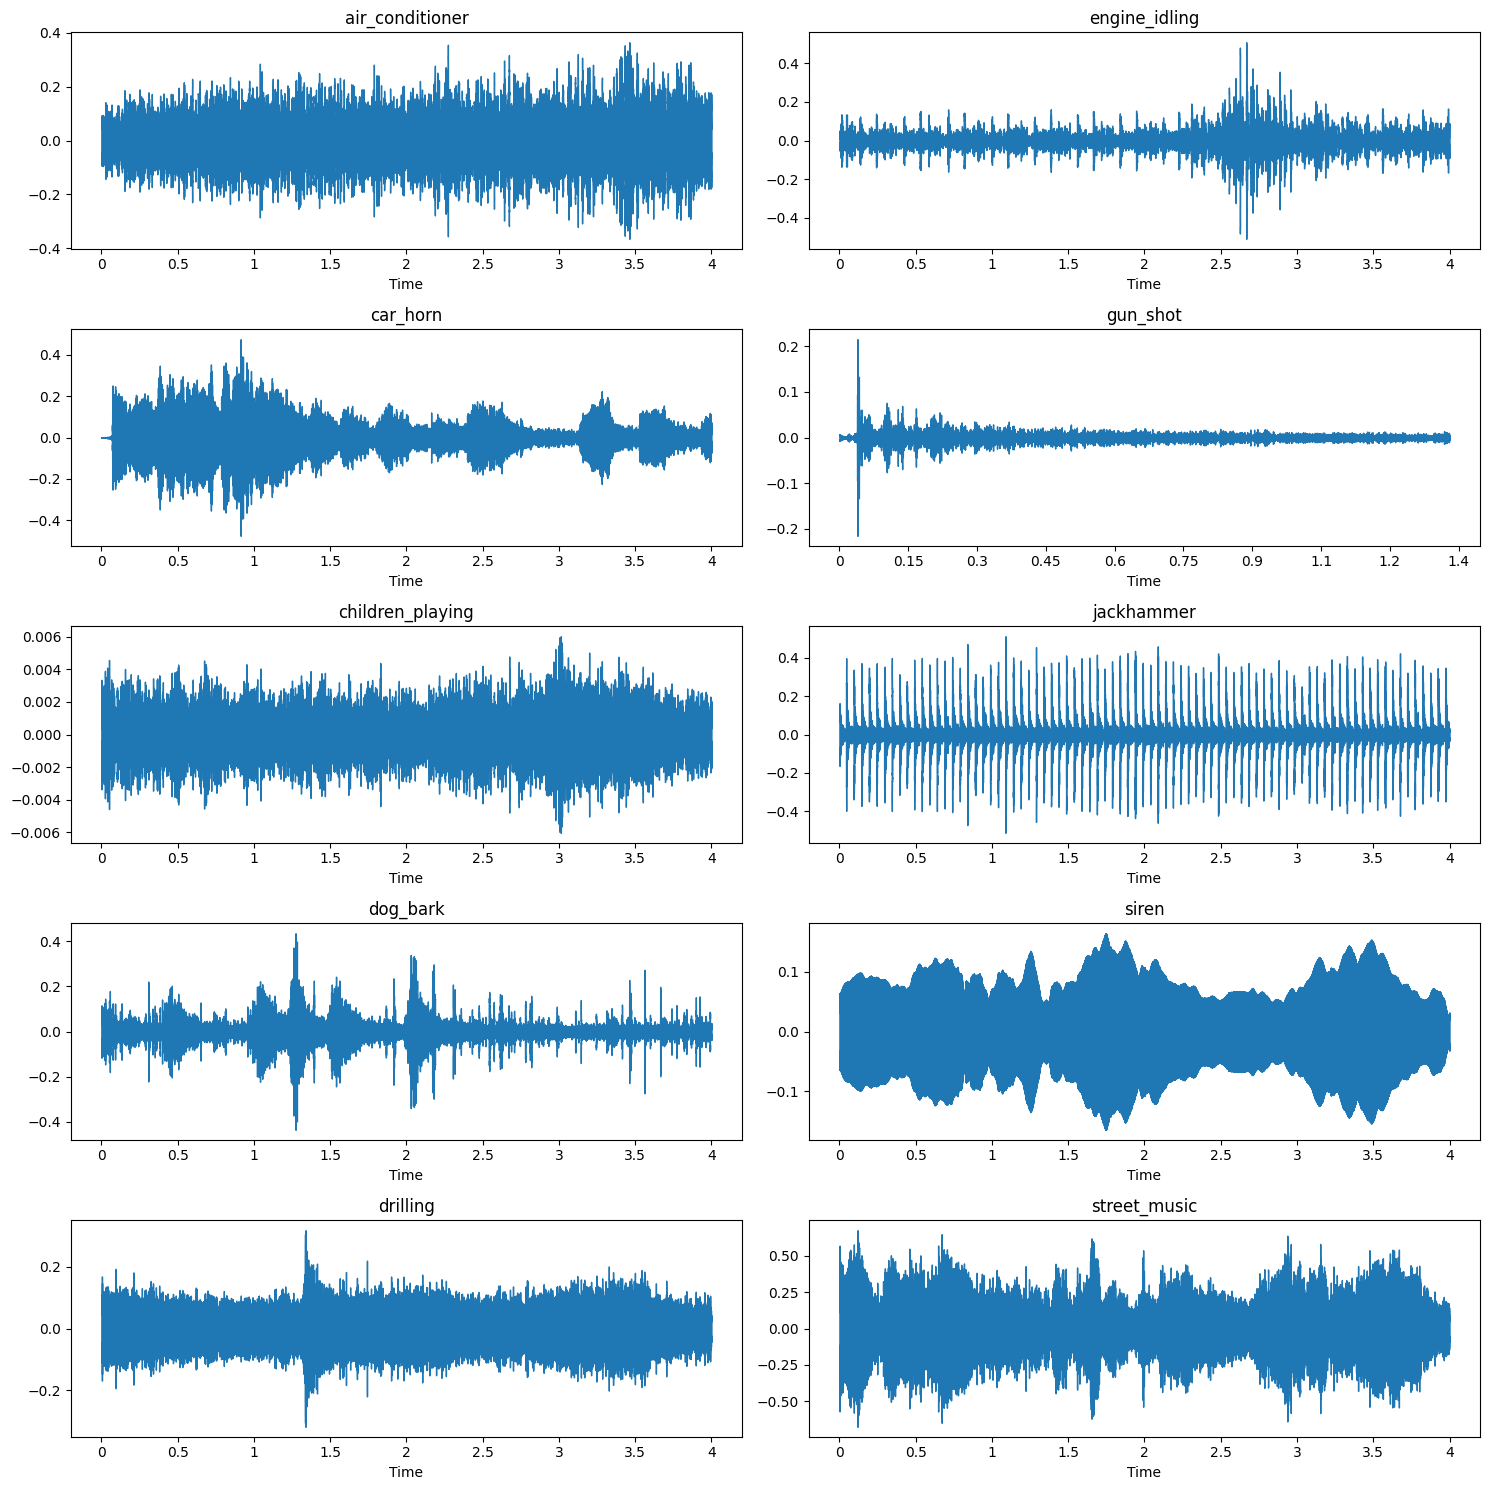

In [37]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Randomly select one sample of each class
random_samples = dataset_df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
index = 0
for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()


MFCC (Mel-Frequency Cepstral Coefficients), STFT (Short-Term Fourier Transform), and Mel-Spectograms are three widely used techniques for processing audio signals and producing features that are fed into machine learning algorithms like convolutional neural networks.


### STFT (Log Y Axis)

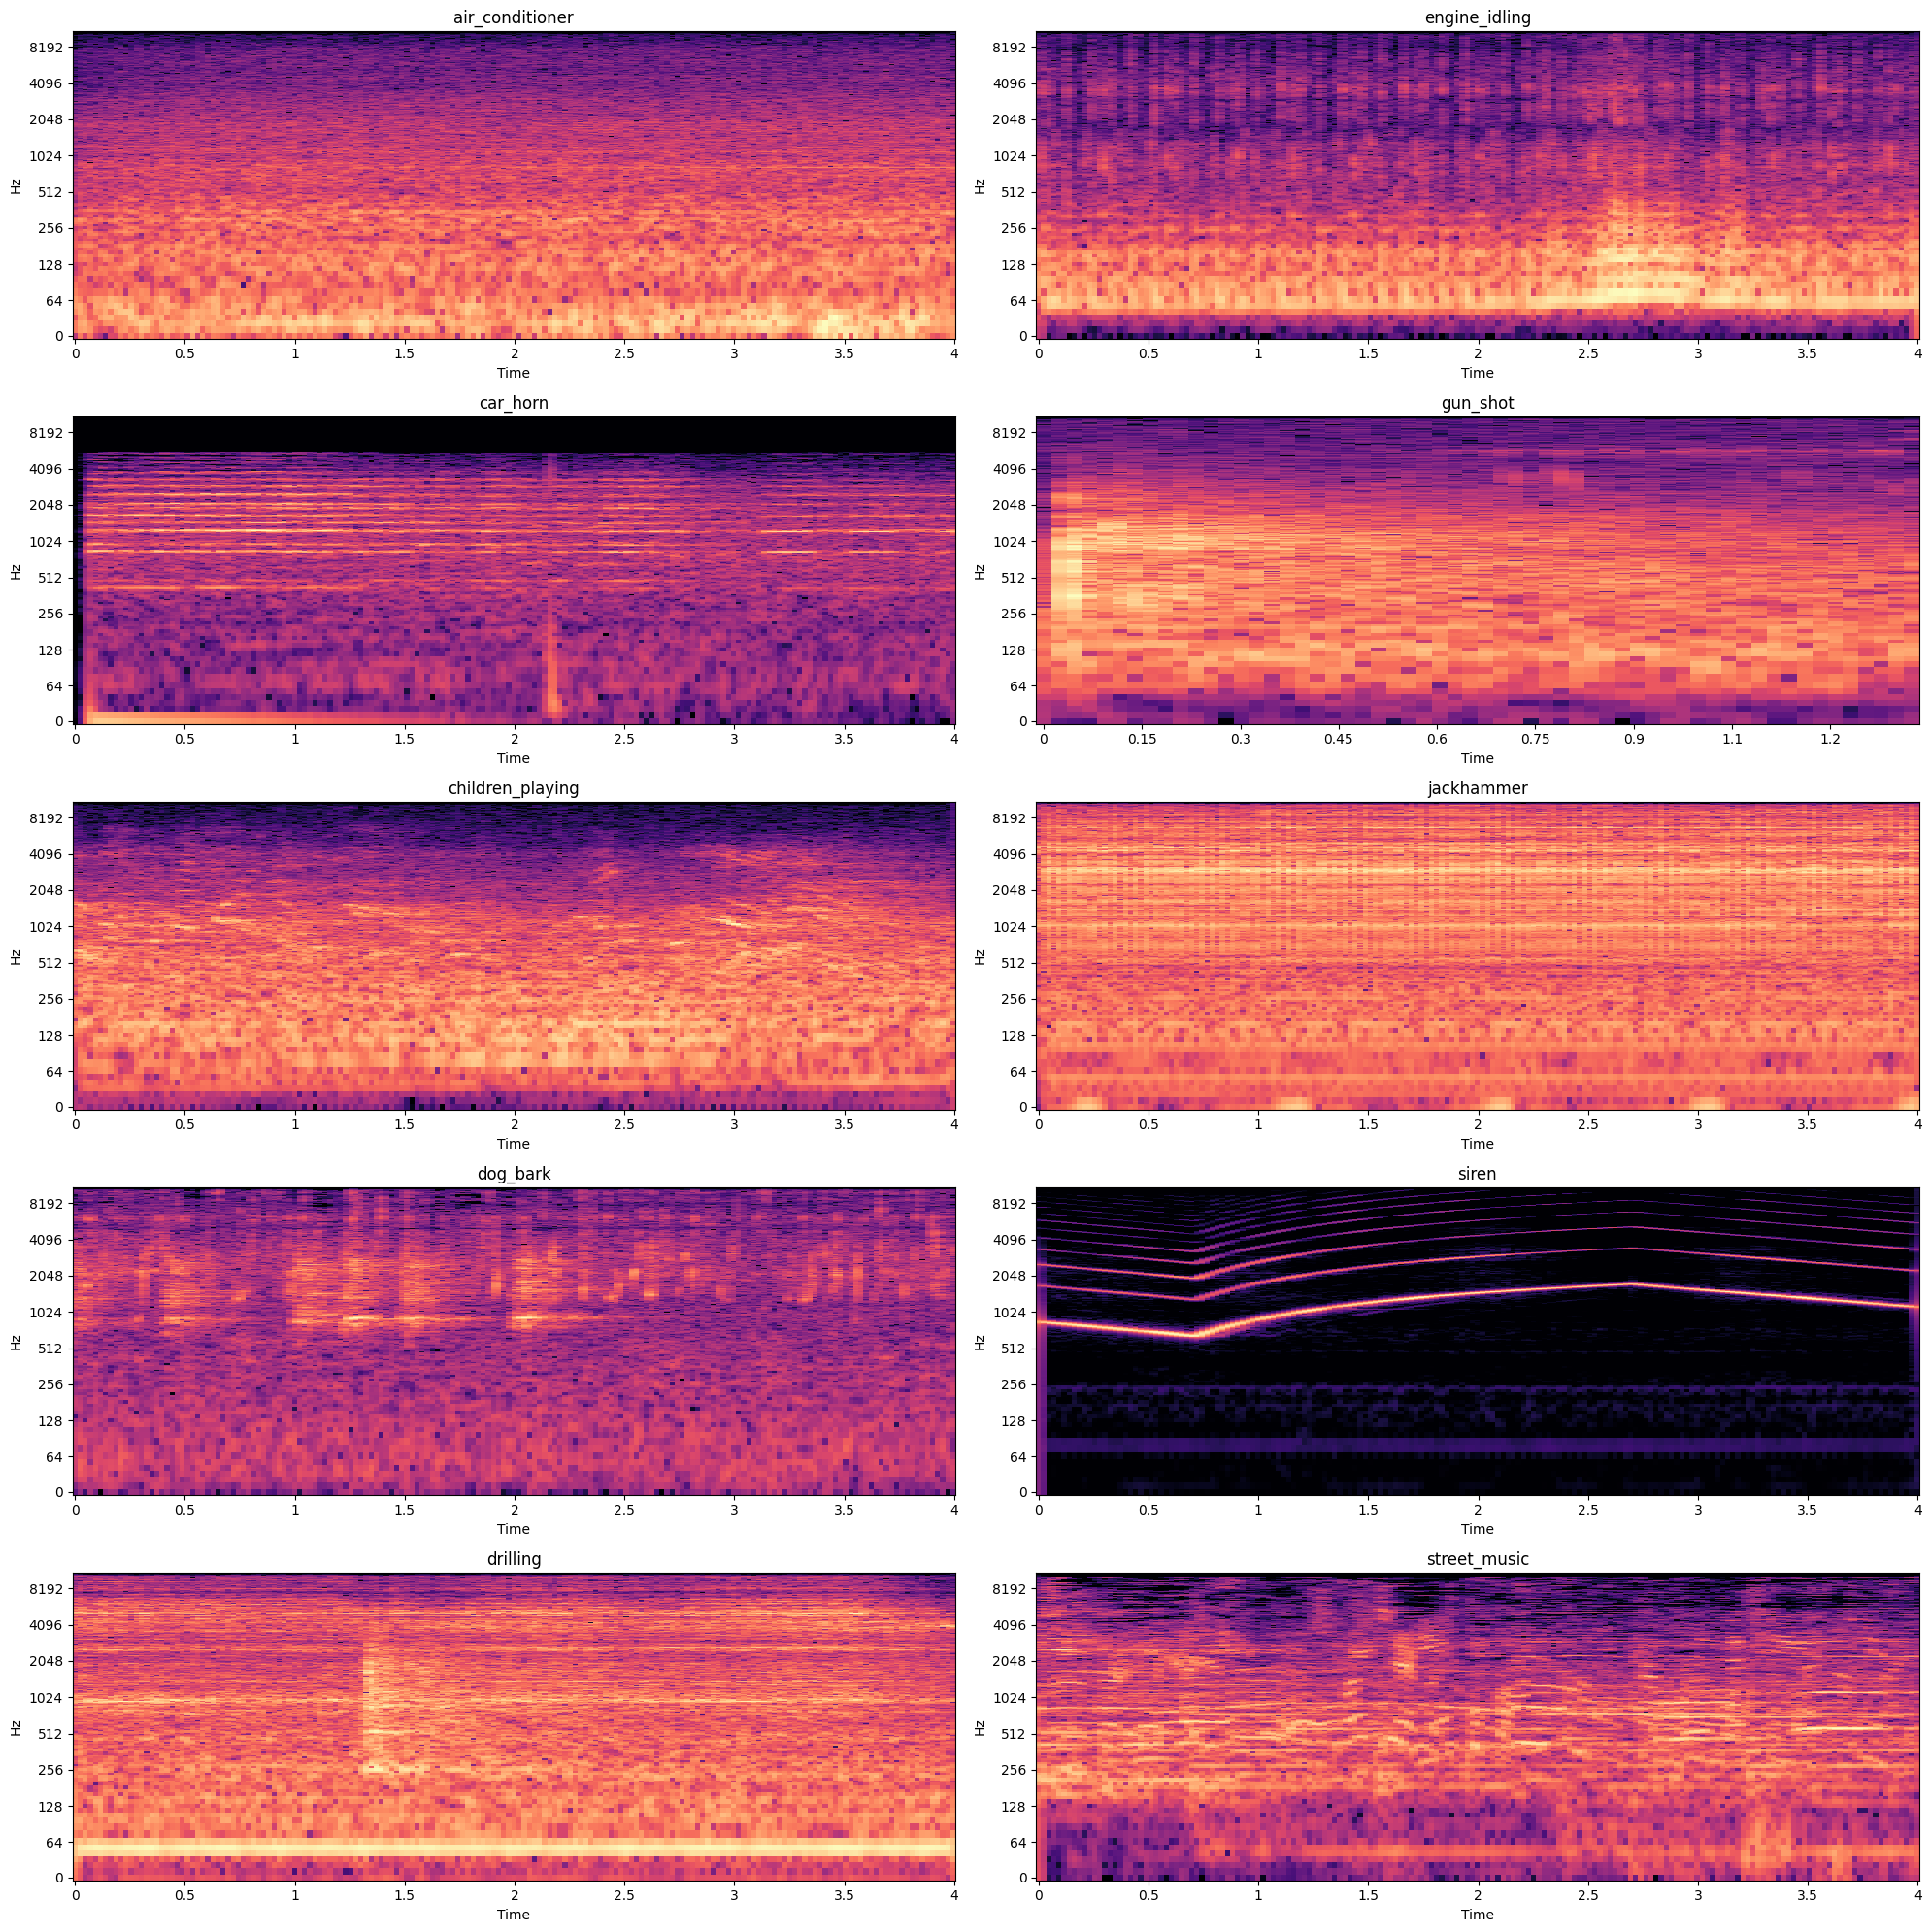

In [39]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Visualize the STFT
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        librosa.display.specshow(S_db,
                                 sr=sample_rate,
                                 hop_length=hop_length,
                                 x_axis="time",
                                 y_axis='log',
                                 ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()


### Mel-Spectogram

The Mel-Spectogram, which shows the various frequency magnitudes at various timesteps, will then be visualized. The frequency magnitude is converted to a form on the Mel Scale, which considers the perception and processing of audio signals by humans.



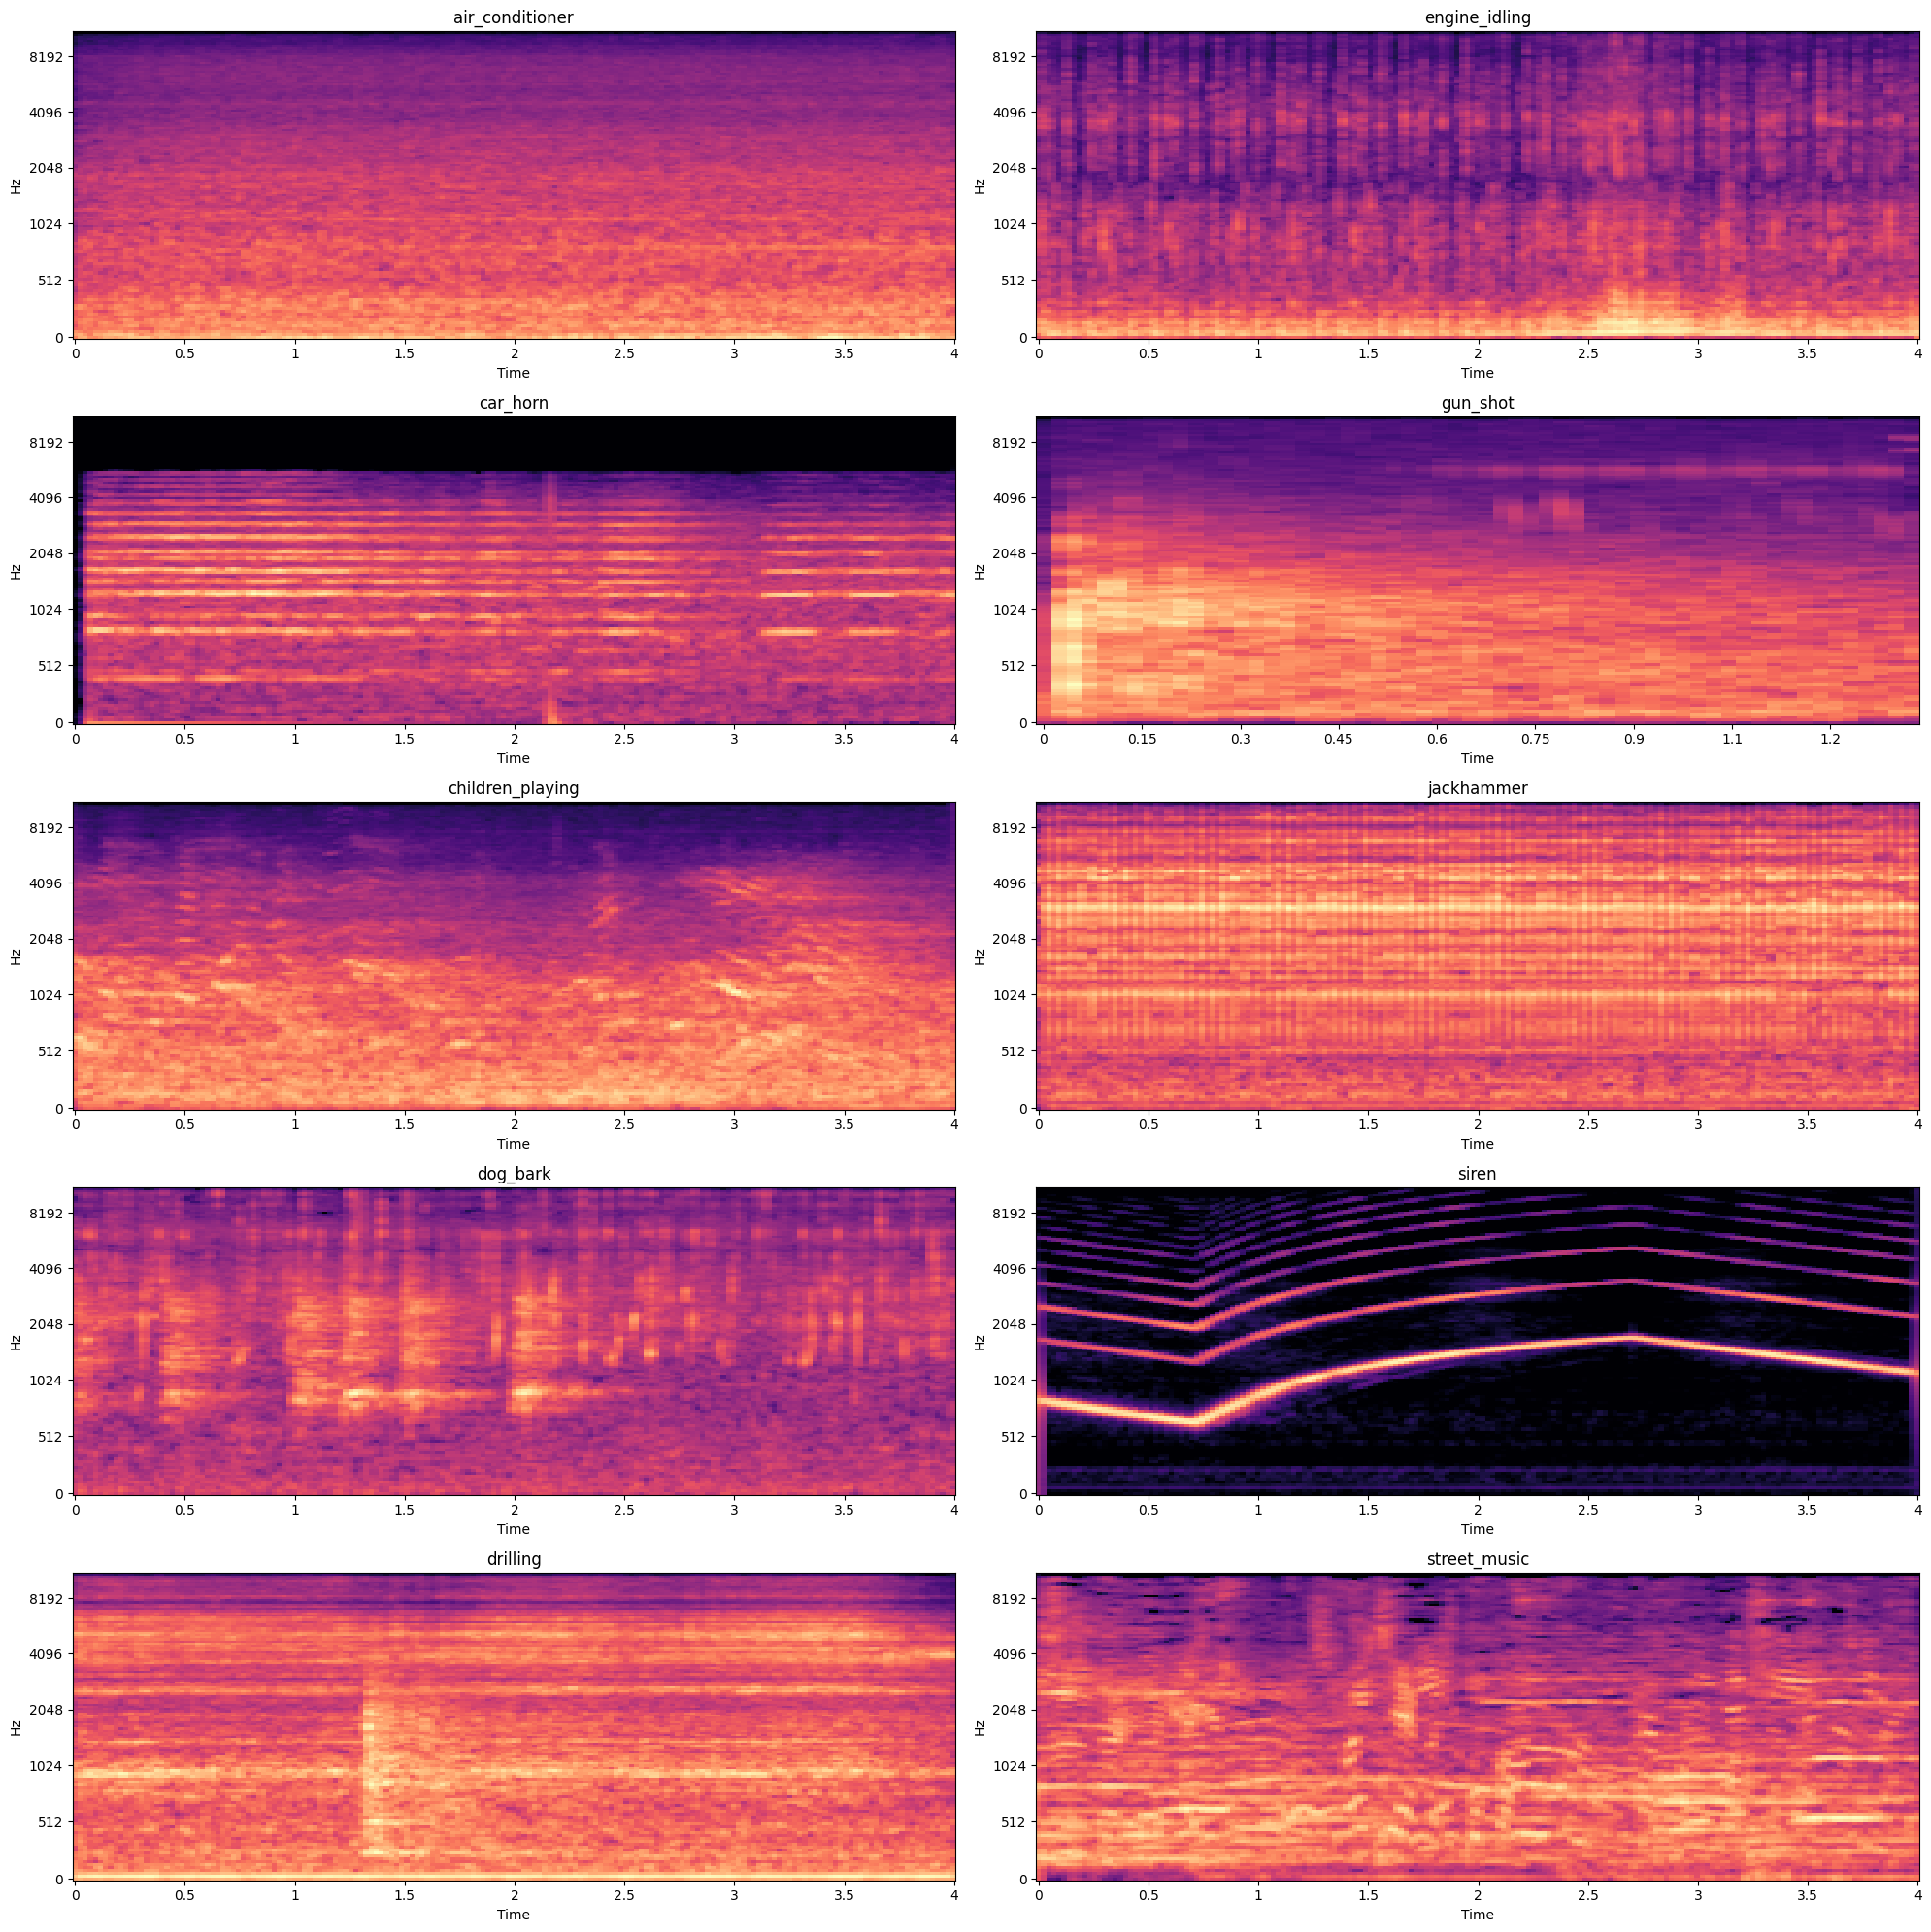

In [41]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Visualize the Mel-Spectrograms
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        stft = librosa.stft(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
        mel_spec = librosa.feature.melspectrogram(S=np.abs(stft)**2, sr=sample_rate)
        S_db_mel = librosa.power_to_db(mel_spec, ref=np.max)
        librosa.display.specshow(S_db_mel,
                                 sr=sample_rate,
                                 hop_length=hop_length,
                                 x_axis="time",
                                 y_axis='mel',
                                 ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()


In [42]:
# Listen to the recordings (index can be changed to listen to a different recording)
index = 0
print('Listen to {} sample'.format(labels[index]))
IPython.display.Audio(audio_samples[index])

Listen to air_conditioner sample


In [43]:
audio_file, sample_rate = librosa.load(audio_samples[0])
stft = librosa.stft(audio_file)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
print(S_db.shape)
S_db

(1025, 173)


array([[-39.714836, -21.91955 , -33.899292, ..., -26.305569, -22.425425,
        -18.179113],
       [-22.286547, -16.533663, -15.3095  , ..., -18.286272, -16.562134,
        -16.49241 ],
       [-21.97376 , -14.796867, -13.32065 , ..., -15.090279, -14.017494,
        -14.098087],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -72.39734 ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -72.40013 ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -72.399826]], dtype=float32)

### MFCCs

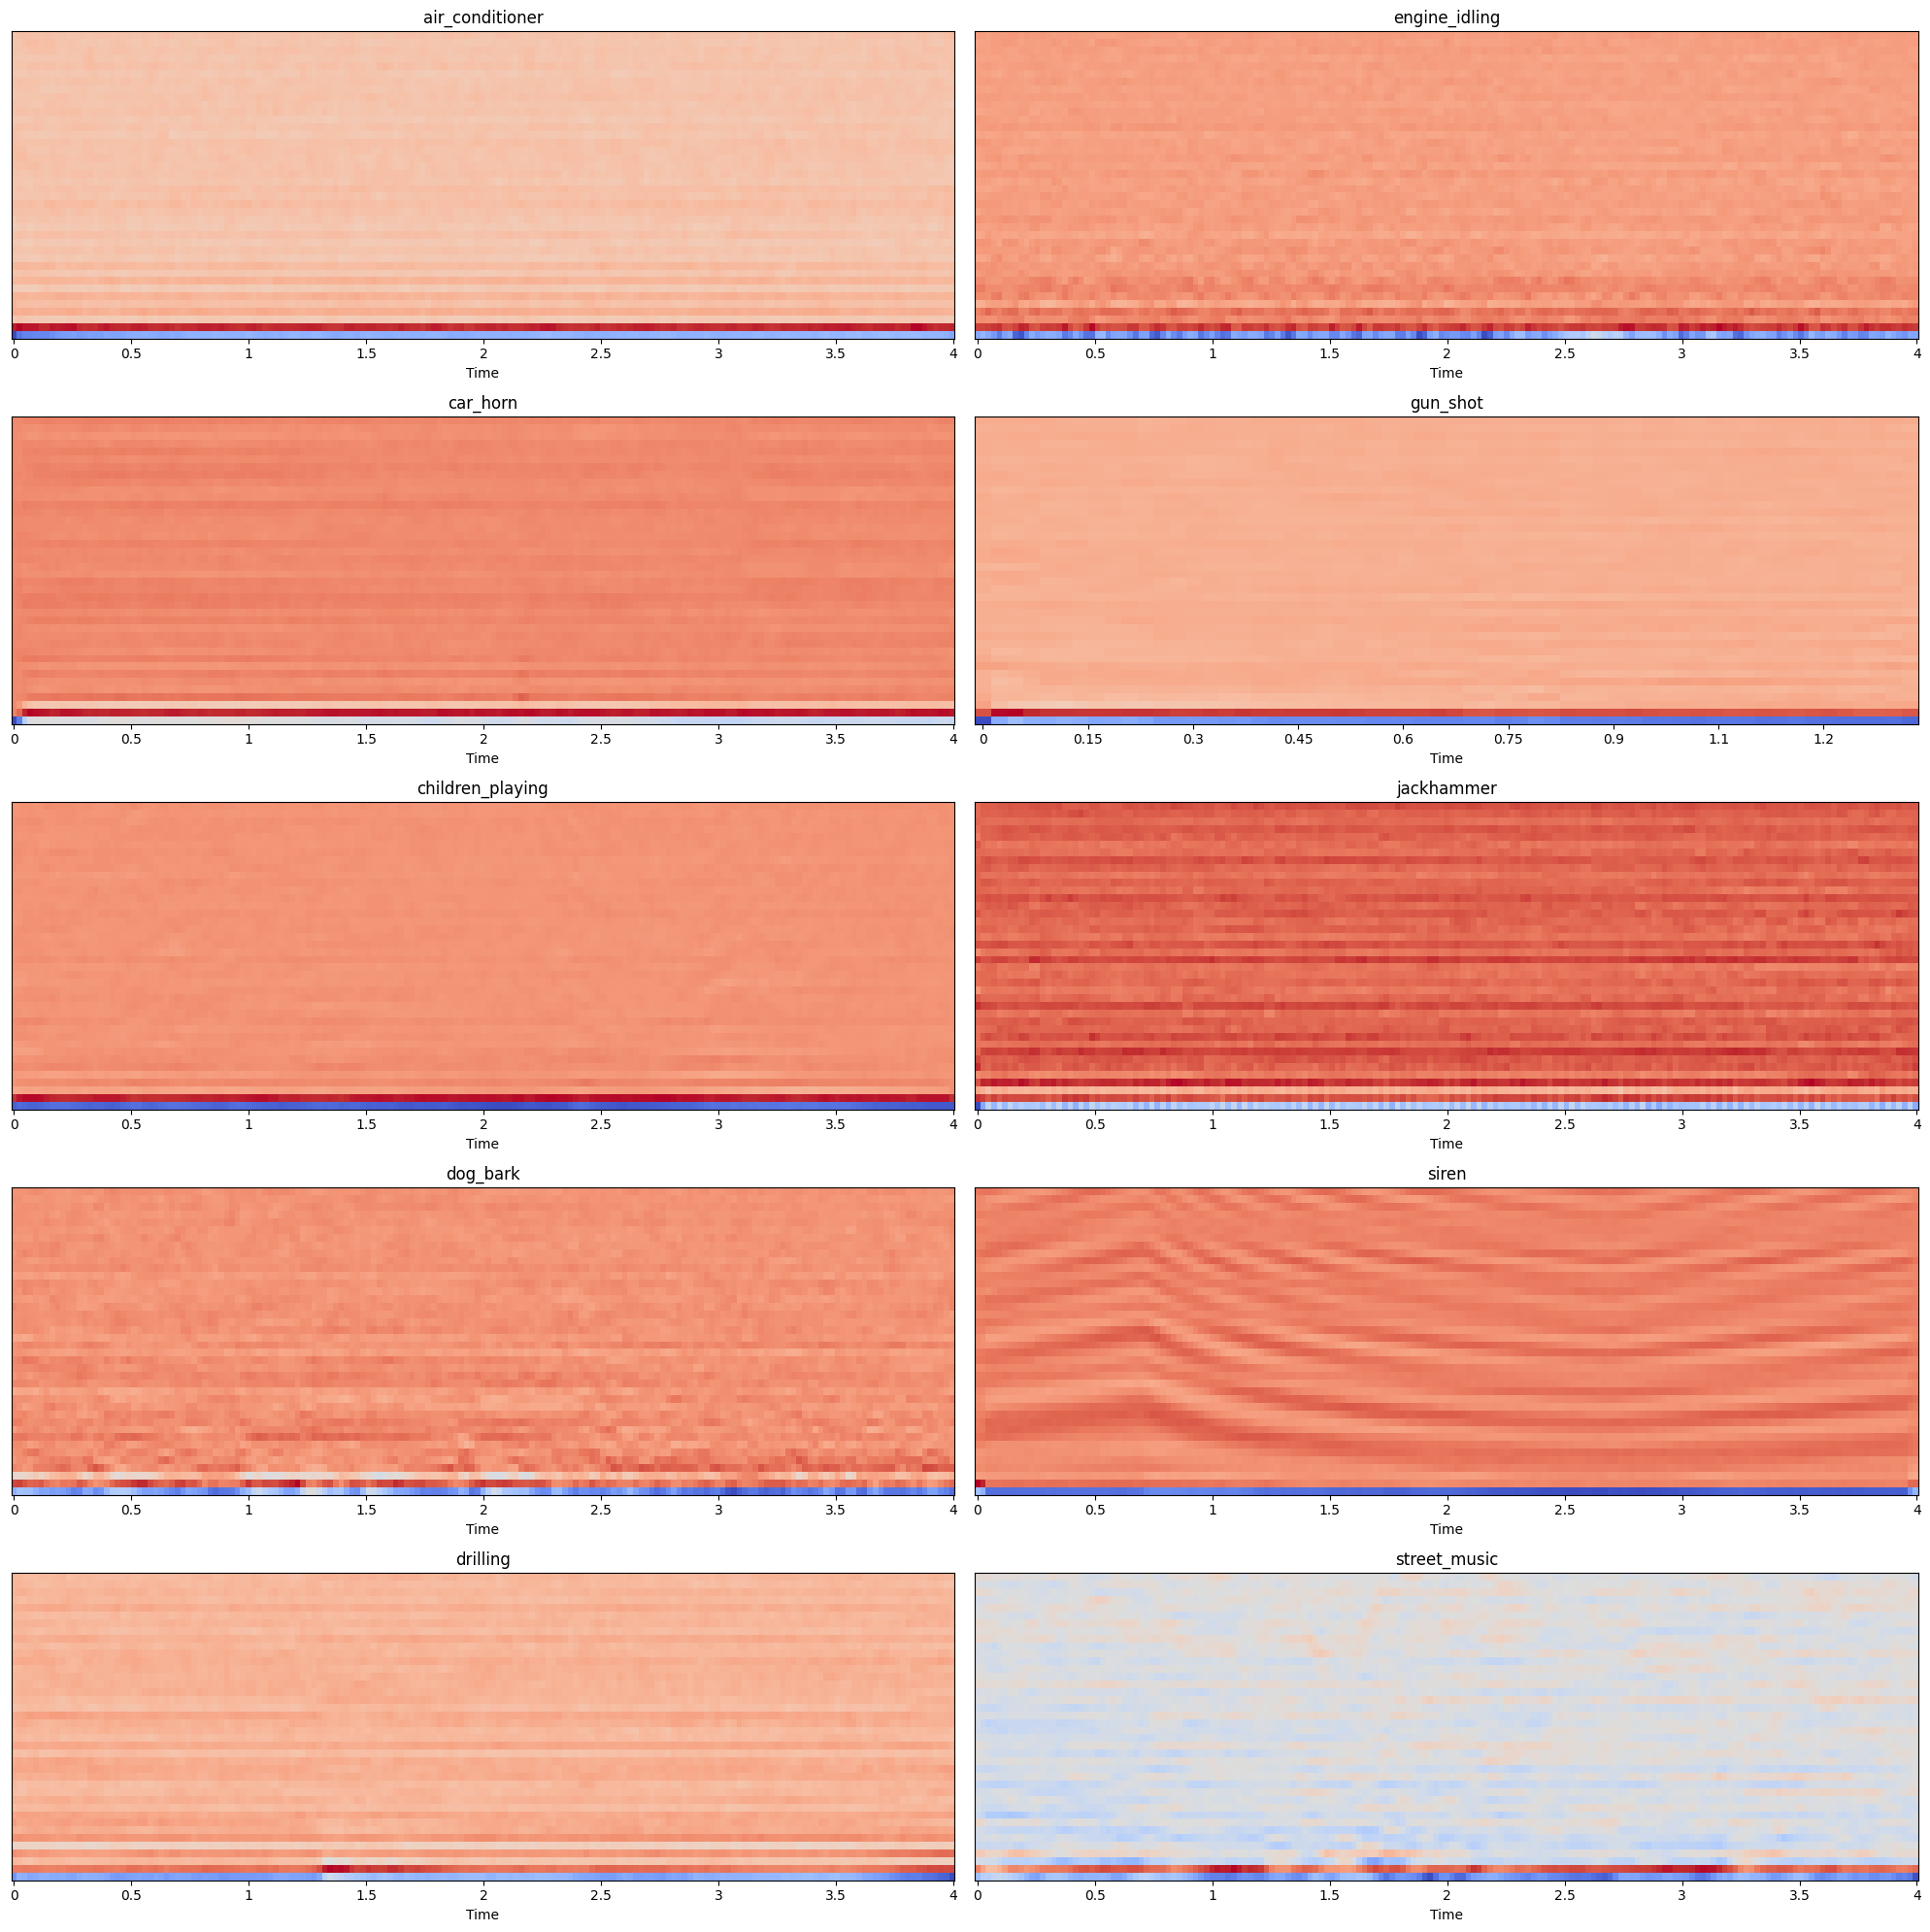

In [45]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Visualize 40 MFCCs
n_fft = 2048
hop_length = 512
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
index = 0
n_s = 4

for col in range(2):
    for row in range(5):
        audio_file, sample_rate = librosa.load(audio_samples[index])
        mfccs = librosa.feature.mfcc(y=audio_file,
                                     sr=sample_rate,
                                     n_fft=n_fft,
                                     hop_length=hop_length,
                                     n_mfcc=40)
        librosa.display.specshow(mfccs,
                                 sr=sample_rate,
                                 hop_length=hop_length,
                                 x_axis="time",
                                 ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1

fig.tight_layout()
plt.show()


We can see that the signals for the dataset classes are sufficiently different to be correctly classified after looking at the graphs for a few different permutations.

From this point on, we can process the data and categorize the various audio files using machine learning algorithms.


## Applying Machine Learning on Sound Data
# Install Packages
**We install:**

Machine learning libraries: Keras, sklearn

Audio processing: librosa

Plots: Plotly, matplotlib

In [46]:
!pip install pandas
!pip install setuptools
!pip install numpy
!pip install sklearn
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install pillow
!pip install keras

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [47]:
!pip install --upgrade pip
!pip install numpy scipy
!pip install scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [48]:
import os
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

In [49]:
# Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2023-11-27 12:32:39--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2023-11-27 12:32:39--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  26.4MB/s    in 3m 43s  

2023-11-27 12:36:22 (25.8 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



## Design Choices and Models
I have made the following design decisions and recommendations after analyzing the dataset, reading up on the state-of-the-art in audio signal classification, and reviewing some of my earlier work:




Convolutional neural networks can be trained with input from MFCCs, STFTs, or Mel-Spectograms.


* I pad the spectogram that is generated because the audio durations range from 0 to 4 seconds, so each audio is the same length.




Features available:

* Employing MFCCs as attributes:

  * The first 13 MFCCs, their derivatives, and their second derivatives are typically computed and used as features. Alternatively, using 40 MFCCs is customary as it is the Librosa default.

* Using the features of the STFT:

  * Has less human processing than Mel-Spectograms and MFCCs; instead of learning human-designed representations, the CNN might learn other filters.

* Using features from the Mel-Spectogram:

  * A change made to the STFT that simulates how people would hear sound. A little bit more than STFT, but less human engineered than **MFCCs**.


Since it appears that CNNs could benefit more from the frequency-temporal structure, my first choice would be to use STFT and Mel-Spectogram. However, because of **computational resources** and time constraints, I will demonstrate the use of MFCCs as features because they are significantly more memory efficient.



## Splitting and Preprocessing of Datasets
I use Librosa to load all of the audio data at the factory default sample rate of 22050Hz. Source served as the basis for this design choice, though other sample rates might be tested in subsequent studies.


> Since humans have a maximum hearing range of about 20,000 hertz, it is feasible to analyze speech and music data effectively and affordably at much lower frequencies. The highest pitches that typically concern us are approximately C9≈8372 Hz, which is significantly lower than the 11025 cutoff that fs=22050 suggests.




Librosa loads the audio in mono by default, providing us with one channel.


In [50]:
# FeatureExtractor class including librosa audio processing functions
class FeatureExtractor:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.max_audio_duration = 4
        self.dataset_df = self._create_dataset(csv_file)

    @staticmethod
    def _create_dataset(csv_file):
        """
        Args:
            dataset_path: path with the .wav files after unzipping
        Returns: A pandas dataframe with the list of files and labels (`filenames`, `labels`)
        """
        dataset_df = pd.read_csv(csv_file)
        filepaths = []
        for i, row in dataset_df.iterrows():
            filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
        dataset_df['filepath'] = filepaths
        return dataset_df

    @staticmethod
    def _compute_max_pad_length(max_audio_length, sample_rate=22050, n_fft=2048, hop_length=512):
        dummy_file = np.random.random(max_audio_length*sample_rate)
        stft = librosa.stft(dummy_file, n_fft=n_fft, hop_length=hop_length)
        # Return an even number for CNN computation purposes
        if stft.shape[1] % 2 != 0:
            return stft.shape[1] + 1
        return stft.shape[1]

    def compute_save_features(self,
                        mode='mfcc',
                        sample_rate=22050,
                        n_fft=2048,
                        hop_length=512,
                        n_mfcc=40,
                        output_path='features',
                        deltas=False
                        ):
        dataset_features = []
        max_pad = self._compute_max_pad_length(self.max_audio_duration,
                                               sample_rate=sample_rate,
                                               n_fft=n_fft,
                                               hop_length=hop_length)
        print('Max Padding = ', max_pad)

        if not os.path.exists(output_path):
            print('Creating output folder: ', output_path)
            os.makedirs(output_path)
        else:
            print('Output folder already existed')

        print('Saving features in ', output_path)
        i = 0
        t = time.time()

        features_path = []
        for filepath in self.dataset_df['filepath']:
            if i % 100 == 0:
                print('{} files processed in {}s'.format(i, time.time() - t))
            audio_file, sample_rate = librosa.load(filepath, sr=sample_rate, res_type='kaiser_fast')
            if mode == 'mfcc':
                audio_features = self.compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas)
            elif mode == 'stft':
                audio_features = self.compute_stft(audio_file, sample_rate, n_fft, hop_length)
            elif mode == 'mel-spectogram':
                audio_features = self.compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length)

            audio_features = np.pad(audio_features,
                                    pad_width=((0, 0), (0, max_pad - audio_features.shape[1])))

            save_path = os.path.join(output_path, filepath.split('/')[-1].replace('wav', 'npy'))
            self.save_features(audio_features, save_path)
            features_path.append(save_path)
            i+=1
        self.dataset_df['features_path'] = features_path
        return self.dataset_df

    @staticmethod
    def save_features(audio_features, filepath):
        np.save(filepath, audio_features)

    @staticmethod
    def compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length):
        return librosa.feature.melspectrogram(audio_file,
                                              sr=sample_rate,
                                              n_fft=n_fft,
                                              hop_length=hop_length)
    @staticmethod
    def compute_stft(audio_file, sample_rate, n_fft, hop_length):
        return librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)

    @staticmethod
    def compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas=False):
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate,
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    )
        # Change mode from interpolation to nearest
        if deltas:
          delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
          delta2_mfccs = librosa.feature.delta(mfccs, order=2, mode='nearest')
          return np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return mfccs

In [51]:
# Create dataset and extract features
fe = FeatureExtractor('UrbanSound8K/metadata/UrbanSound8K.csv')

In [53]:
# Unzip features
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H" -O features_mfcc.zip && rm -rf /tmp/cookies.txt
!unzip -q features_mfcc.zip
!rm features_mfcc.zip

--2023-11-27 12:50:03--  https://docs.google.com/uc?export=download&confirm=t&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H
Resolving docs.google.com (docs.google.com)... 64.233.181.138, 64.233.181.102, 64.233.181.100, ...
Connecting to docs.google.com (docs.google.com)|64.233.181.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p4rgkh8rqhfvt8gu2rboeqcbsvffu669/1701089400000/12555612686504083087/*/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download&uuid=b67e376a-2e29-4d77-875e-426782a854c4 [following]
--2023-11-27 12:50:04--  https://doc-00-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p4rgkh8rqhfvt8gu2rboeqcbsvffu669/1701089400000/12555612686504083087/*/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download&uuid=b67e376a-2e29-4d77-875e-426782a854c4
Resolving doc-00-1k-docs.googleusercontent.com (doc-00-1k-docs.googleusercontent.com)... 172.253.114.132,

In [54]:
# Download dataset.json file
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C" -O dataset.json

--2023-11-27 12:50:28--  https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C
Resolving docs.google.com (docs.google.com)... 64.233.181.138, 64.233.181.102, 64.233.181.100, ...
Connecting to docs.google.com (docs.google.com)|64.233.181.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/728dvrv6b38qpbdlq2tfej444gbiu5tc/1701089400000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download&uuid=e6cd9d21-4183-4a9d-995c-a59741146749 [following]
--2023-11-27 12:50:29--  https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/728dvrv6b38qpbdlq2tfej444gbiu5tc/1701089400000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download&uuid=e6cd9d21-4183-4a9d-995c-a59741146749
Resolving doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.googleusercontent.com)... 172.253.114.132, 2607:f8b0

In [55]:
dataset_df = pd.read_json('dataset.json')


We will load all of the data into memory and process it in minibatches for the purposes of this experiment. We could create Dataloader objects, which would enable us to execute numerous other operations like Data Augmentation and iterate more quickly, if we had more time and computational power.




In [56]:
dataset_df['features'] = [np.asarray(np.load(feature_path)) for feature_path in dataset_df['features_path']]


In [57]:
from keras.utils import to_categorical
dataset_df['labels_categorical'] = [to_categorical(label, 10) for label in dataset_df['classID']]

In [58]:
dataset_df.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class                                     filepath  \
0          dog_bark    UrbanSound8K/audio/fold5/100032-3-0-0.wav   
1  children_playing  UrbanSound8K/audio/fold5/100263-2-0-117.wav   
2  children_playing  UrbanSound8K/audio/fold5/100263-2-0-121.wav   
3  children_playing  UrbanSound8K/audio/fold5/100263-2-0-126.wav   
4  children_playing  UrbanSound8K/audio/fold5/100263-2-0-137.wav   

                      features_path  \
0    features_mfcc/100032-3-0-0.npy   
1  features_mfcc/100263-2-0-117.npy   
2  features_mfcc/100263-2-0-121.npy   
3  features_mfcc/100263-2-0-126.npy   
4  features_mfcc/100263-2-0-137.npy   

                                            features  \
0  [[[-306.77255], [-177.59209], [-99.13616], [-6...   
1  [[[-457.69534], [-451.0248], [-450.68613], [-4...   
2  [[[-468.0367], [-467.42264], [-481.04654], [-4...   
3  [[[-422.42215], [-411.9085], [-409.46243], [-4...   
4  [[[-438.10162], [-434.47787], [-443.3284], [-4...   

                                  labels_categorical  
0  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

We are going to create splits for the train, validation and test sets of our dataset. For the purpose of the experiment and to make it quick we will use the sklearn function **train_test_split**, two times.



In [59]:
# Split the dataset
from sklearn.model_selection import train_test_split

# Add one dimension for the channel
X = np.array(dataset_df['features'].tolist())
y = np.array(dataset_df['labels_categorical'].tolist())

# As there is unbalance for some classes I am going to stratify it so we have the same proportion in train/test
X_train, X_test, Y_train, Y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    random_state=1,
                                                    stratify=y)
# Create validation and test
X_test, X_val, Y_test, Y_val = train_test_split(X_test,
                                                Y_test,
                                                test_size=0.5,
                                                random_state=1,
                                                stratify=Y_test)

print(X_train.shape, X_val.shape, X_test.shape)

(6112, 39, 174, 1) (1310, 39, 174, 1) (1310, 39, 174, 1)


## Machine Learning Model

#Model Design
We are going to use Keras running over Tensorflow with several layers to create a **Fully Convolutional Network Model**.




In [60]:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

Since our images are rectangular in shape (time is on the x axis, and the y axis represents the MFCC), we will use rectangular filters rather than the more common square filters to improve the way the MFCCs correlate with time.


In [61]:
# FCN Model
def create_model(num_classes=10, input_shape=None, dropout_ratio=None):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
    model.add(Conv2D(filters=16, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 3)))
    model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    model.add(GlobalAveragePooling2D())
    if dropout_ratio is not None:
        model.add(Dropout(dropout_ratio))
    # Add dense linear layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

We will apply the Categorical Cross Entropy loss because it is a multiclass problem. We will use Adam's Keras implementation as the optimizer, using the default values for the hyperparameters.


In [62]:
# Create and compile the model
fcn_model = create_model(input_shape=X_train.shape[1:])
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 171, 16)       144       
                                                                 
 max_pooling2d (MaxPooling2  (None, 19, 57, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 54, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 27, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 24, 64)         16448     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 12, 64)         0

# Model training and evaluation

In [63]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [64]:
def train_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, callbacks):
    model.fit(X_train,
              Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_val, Y_val),
              callbacks=callbacks, verbose=1)
    return model

The model that performs better on the validation set will be chosen to serve as our checkpoint for **early stopping**.

Our ability to perform hyperparameter tuning more quickly will come from building a function to train the model.


In [65]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)
callbacks = [checkpointer]

# Hyper-parameters
epochs = 100
batch_size = 256

In [66]:
# Train the model
model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 1.9253 - accuracy: 0.3248
Epoch 1: val_accuracy improved from -inf to 0.42366, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 35s 1s/step - loss: 1.9253 - accuracy: 0.3248 - val_loss: 1.5619 - val_accuracy: 0.4237
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - ETA: 0s - loss: 1.3619 - accuracy: 0.5160
Epoch 2: val_accuracy improved from 0.42366 to 0.54046, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 35s 1s/step - loss: 1.3619 - accuracy: 0.5160 - val_loss: 1.2455 - val_accuracy: 0.5405
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 1.1344 - accuracy: 0.6104
Epoch 3: val_accuracy improved from 0.54046 to 0.61298, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 40s 2s/step - loss: 1.1344 - accuracy: 0.6104 - val_loss: 1.0987 - val_accuracy: 0.6130
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.6657
Epoch 4: val_accuracy improved from 0.61298 to 0.63664, saving model to saved_models/best_fcn.hdf5
24/24 [==============================] - 27s 1s/step - loss: 0.9766 - accuracy: 0.6657 - val_loss: 1.0134 - val_accuracy: 0.6366
Epoch 5/100
24/24 [========================

In [67]:
# Load the best model
best_model = load_model('saved_models/best_fcn.hdf5')

Looks like the model has overfitted to the training data towards the end of the training. We have selected the model that performed better on the validation set, saved by the checkpoint. The similarity between validation and test score tells us that our training methodology is correct and that our validation set is a good estimator of testing performance.

In [68]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])


Training Accuracy:  0.9991819262504578
Validation Accuracy:  0.9251908659934998
Testing Accuracy:  0.903816819190979


We see that there has been overfitting so we could train another model adding dropout before the last layer to add more regularization.



In [69]:
# We add a dropout ratio of 0.25
fcn_model = create_model(input_shape=X_train.shape[1:], dropout_ratio=0.5)
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 38, 171, 16)       144       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 19, 57, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 54, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 9, 27, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 24, 64)         16448     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 12, 64)        

In [70]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn_dropout.hdf5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
callbacks = [checkpointer]

model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=200,
                    batch_size=256,
                    callbacks=callbacks)

Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 2.2209 - accuracy: 0.2322
Epoch 1: val_accuracy improved from -inf to 0.40153, saving model to saved_models/best_fcn_dropout.hdf5
24/24 [==============================] - 34s 1s/step - loss: 2.2209 - accuracy: 0.2322 - val_loss: 1.7105 - val_accuracy: 0.4015
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 1.6369 - accuracy: 0.4035
Epoch 2: val_accuracy improved from 0.40153 to 0.50000, saving model to saved_models/best_fcn_dropout.hdf5
24/24 [==============================] - 29s 1s/step - loss: 1.6369 - accuracy: 0.4035 - val_loss: 1.4081 - val_accuracy: 0.5000
Epoch 3/200
24/24 [==============================] - ETA: 0s - loss: 1.4392 - accuracy: 0.4967
Epoch 3: val_accuracy improved from 0.50000 to 0.57252, saving model to saved_models/best_fcn_dropout.hdf5
24/24 [==============================] - 29s 1s/step - loss: 1.4392 - accuracy: 0.4967 - val_loss: 1.2224 - val_accuracy: 0.5725
Epoch 4/20

In [71]:
best_model = load_model('saved_models/best_fcn_dropout.hdf5')

In [72]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9972186088562012
Validation Accuracy:  0.9229007363319397
Testing Accuracy:  0.9045801758766174


In [73]:
# Plot a confusion matrix
from sklearn import metrics
Y_pred = best_model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

41/41 [==============================] - 2s 30ms/step


In [74]:
# Confusion matrix code (from https://github.com/triagemd/keras-eval/blob/master/keras_eval/visualizer.py)
def plot_confusion_matrix(cm, concepts, normalize=False, show_text=True, fontsize=18, figsize=(16, 12),
                          cmap=plt.cm.coolwarm_r, save_path=None, show_labels=True):
    '''
    Plot confusion matrix provided in 'cm'
    Args:
        cm: Confusion Matrix, square sized numpy array
        concepts: Name of the categories to show
        normalize: If True, normalize values between 0 and ones. Not valid if negative values.
        show_text: If True, display cell values as text. Otherwise only display cell colors.
        fontsize: Size of text
        figsize: Size of figure
        cmap: Color choice
        save_path: If `save_path` specified, save confusion matrix in that location
    Returns: Nothing. Plots confusion matrix
    '''

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError('Invalid confusion matrix shape, it should be square and ndim=2')

    if cm.shape[0] != len(concepts) or cm.shape[1] != len(concepts):
        raise ValueError('Number of concepts (%i) and dimensions of confusion matrix do not coincide (%i, %i)' %
                         (len(concepts), cm.shape[0], cm.shape[1]))

    plt.rcParams.update({'font.size': fontsize})

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm_normalized

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, vmin=np.min(cm), vmax=np.max(cm), alpha=0.8, cmap=cmap)

    fig.colorbar(cax)
    ax.xaxis.tick_bottom()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

    if show_labels:
        n_labels = len(concepts)
        ax.set_xticklabels(concepts)
        ax.set_yticklabels(concepts)
        plt.xticks(np.arange(0, n_labels, 1.0), rotation='vertical')
        plt.yticks(np.arange(0, n_labels, 1.0))
    else:
        plt.axis('off')

    if show_text:
        # http://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
        min_val, max_val = 0, len(concepts)
        ind_array = np.arange(min_val, max_val, 1.0)
        x, y = np.meshgrid(ind_array, ind_array)
        for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
            c = cm[int(x_val), int(y_val)]
            ax.text(y_val, x_val, c, va='center', ha='center')

    if save_path is not None:
        plt.savefig(save_path)

Plotting the confusion matrix helps us observe the model's performance and errors made across classes more clearly.

Since the dataset is largely balanced in our case, accuracy is a useful metric. However, we noticed that some classes (**1car_horn, gun_shot, and siren**) have fewer samples, so it will be interesting to see how these classes perform.

Since many errors are occurring between classes **children_playing and class street_music**, it might be worthwhile to invest a little more time in conducting analysis and determining potential causes.


In [75]:
class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

<ipython-input-74-2680bce05b12>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(concepts)
<ipython-input-74-2680bce05b12>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(concepts)


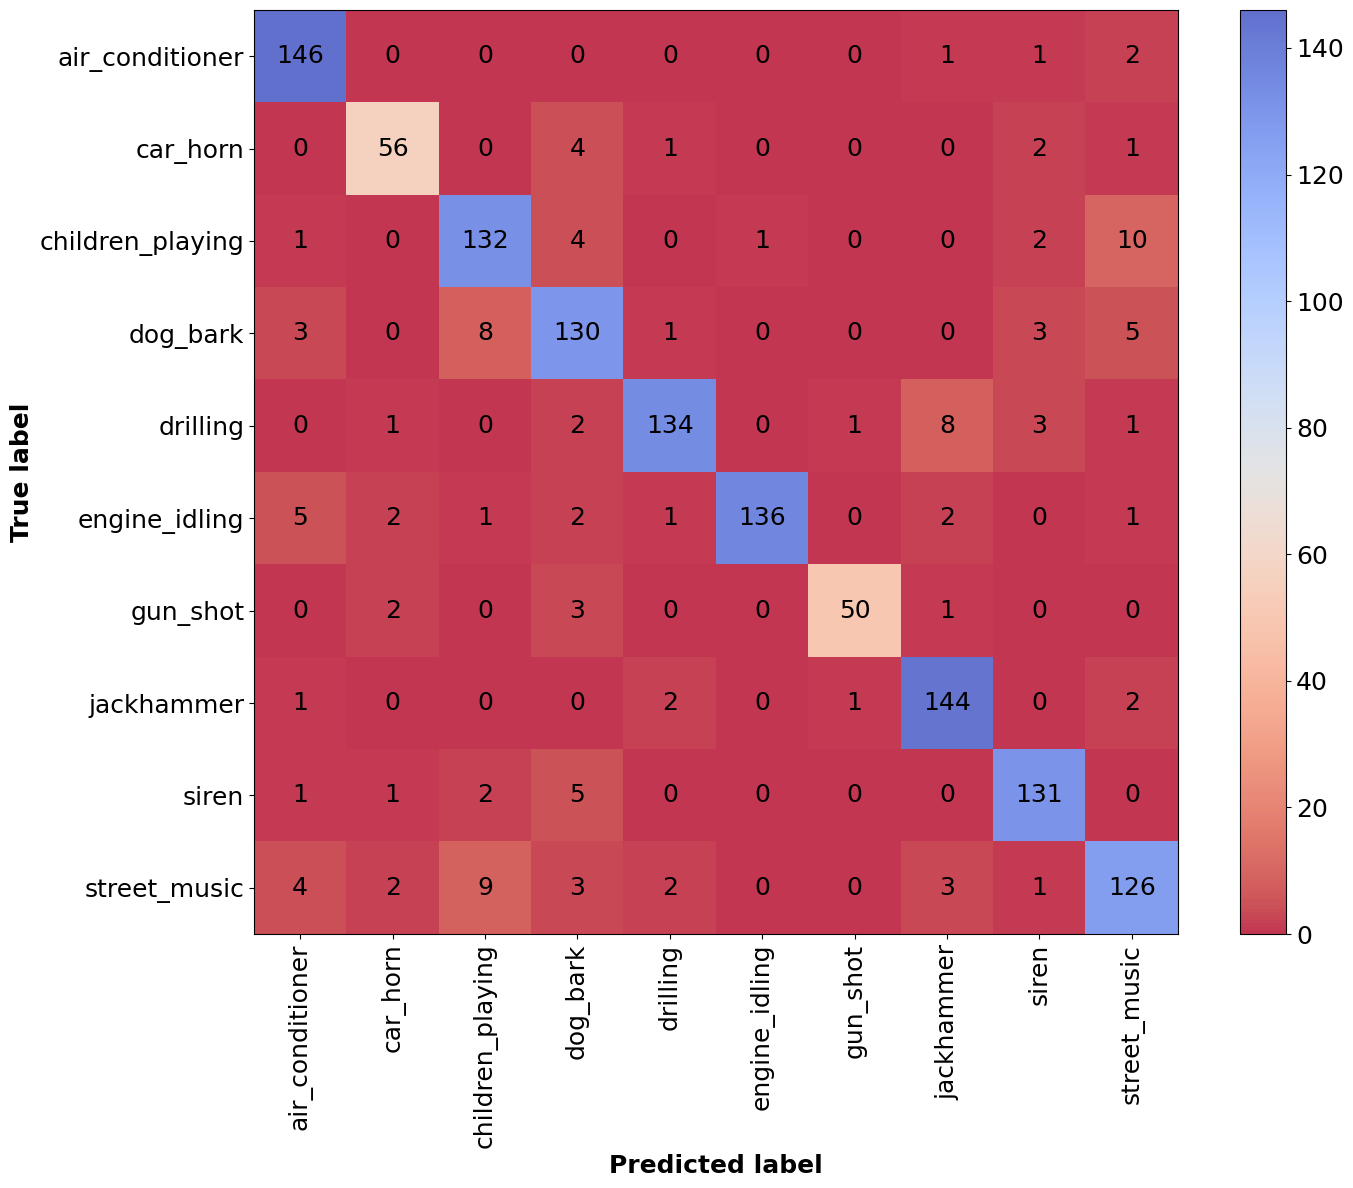

In [76]:
plot_confusion_matrix(matrix, classes)

### Final Thoughts
The test set accuracy shows a 1-2% increase when dropout is added as regularization. This demonstrates that adding it to our model has been successful.

We can attempt a variety of things to enhance the model's performance, including:

* Adjusting hyperparameters:

  * adjusting feature extraction parameters;
  * adjusting network parameters (layer count, pooling layer count, number and filter shape, etc.); * adjusting network hyperparameters (learning rate, optimizer)

* Extraction of features:

  * Use STFT: Compared to MFCCs, the raw spectogram may give the CNN more information to understand the relationship between frequency and time.
  * Use the Mel-Spectogram: Compared to the MFCCs, the Mel-Spectogram may give the CNN more information to understand the relationship between frequency and time.